# Study the distribution of IHC cases

In [1]:
from pathlib import Path
import pickle as pkl
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.ensemble import IsolationForest

In [2]:
ihc_reasons_file = Path('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/documents/IHC_reasons.csv')
ihc_reasons = pd.read_csv(ihc_reasons_file)
for r in sorted(set(ihc_reasons['IHC reason']), key=lambda r: int(r[0])):
    print(r + '\n')

11. No time to review so IHC ordered pre emptively

1. A small length of cancer (e.g. for CV would be <1mm) of any cancer that we are fairly confident of calling cancer morphologically and are confirming with IHC

10. Inflammation

2. Foci that are suspicious of are cancer but only consist of a couple of glands such that we are unlikely to definitively call the focus cancer, but if lack basal cells will be ASAP

3. Odd areas that we are not sure about morphologically what the diagnosis will ultimately be

4. A longer length of cancer which has an unusual appearance e.g. well differentiated cancer or cancer with very few well differentiated glands widely spaced by benign/stroma. Or variant/unusual e.g. clear cell change/atrophic variant/PIN like adenocarcinoma

5. Foci that are atypical but probably atrophic (benign)

6. Small glands around PIN ? small foci of invasion or ASAP or just PIN

9. Other and then explain in further details column



In [3]:
ihc_reasons['IHC_reason_num'] = ihc_reasons['IHC reason'].map(lambda r: int(r[0]))

Text(0.5, 1.0, 'IHC order reasons')

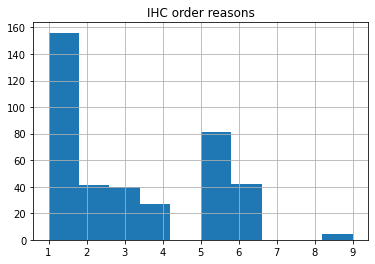

In [4]:
ihc_reasons['IHC_reason_num'].hist()
plt.title('IHC order reasons')

# View the PCAed features of the training and validation datasets (classify-distribution)

In [5]:
from sklearn.decomposition import PCA
import numpy as np
import json
import joblib

In [6]:
with open('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_07_12_20_01_latest/signatures.json', 'r') as clinical_data_file:
    clinical_dataset = json.load(clinical_data_file)

In [7]:
# with open('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_07_12_20_01_validation_latest_RICHARD/signatures.json', 'r') as validation_data_file:
#     validation_dataset = json.load(validation_data_file)
with open('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_07_12_20_01_validation_latest_LISA/signatures.json', 'r') as validation_data_file:
    validation_dataset = json.load(validation_data_file)

In [8]:
with open('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_07_12_20_01_latest/signatures_scaler.joblib', 'rb') as scaler_file:
    scaler = joblib.load(scaler_file)

/Users/andreachatrian/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
train_signatures, test_signatures, train_labels, test_labels = (np.array(clinical_dataset['train_signatures']), np.array(clinical_dataset['test_signatures']), 
                                                                np.array(clinical_dataset['train_labels']), np.array(clinical_dataset['test_labels']))

In [10]:
train_signatures, test_signatures = scaler.transform(train_signatures), scaler.transform(test_signatures)

In [11]:
validation_signatures, validation_labels = np.array(validation_dataset['test_signatures']), np.array(validation_dataset['test_labels'])
validation_signatures = scaler.transform(validation_signatures)

In [12]:
pca = PCA(2)

In [13]:
pca = pca.fit(np.concatenate((train_signatures, test_signatures, validation_signatures), axis=0))

In [14]:
d2_train, d2_test, d2_validation = pca.transform(train_signatures), pca.transform(test_signatures), pca.transform(validation_signatures)

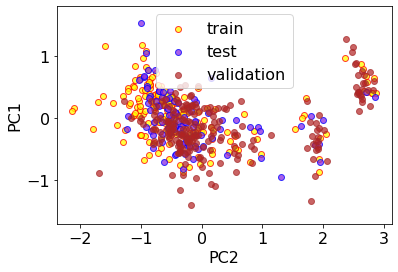

In [17]:
# colored by dataset of origin
plt.scatter(d2_train[:, 0], d2_train[:, 1], color='yellow', edgecolor='r', alpha=0.75)
plt.scatter(d2_test[:, 0], d2_test[:, 1], color='blueviolet', edgecolor='b', alpha=0.75)
plt.scatter(d2_validation[:, 0], d2_validation[:, 1], color='firebrick', edgecolor='brown', alpha=0.7)
plt.ylabel('PC1', fontsize=16)
plt.xlabel('PC2', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.gca().set_ylim((-1.7, 1.8))
# plt.title('Slide signatures for all datasets', fontsize=20)
plt.legend(['train', 'test', 'validation'], fontsize=16)
plt.savefig('/Users/andreachatrian/Google_Drive/Projects/IHC/paper_figures/train_test_validation_manifold.svg')

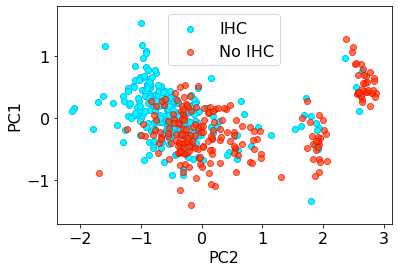

In [18]:
train_color = ['r' if label else 'b' for label in train_labels]
test_color = ['r' if label else 'b' for label in test_labels]
validation_color = ['r' if label else 'b' for label in validation_labels]
ihc = np.concatenate((
    d2_train[np.array(train_color) == 'r'], 
    d2_test[np.array(test_color) == 'r'], 
    d2_validation[np.array(validation_color) == 'r'], 
))
no_ihc = np.concatenate((
    d2_train[np.array(train_color) == 'b'], 
    d2_test[np.array(test_color) == 'b'], 
    d2_validation[np.array(validation_color) == 'b'], 
))
plt.scatter(ihc[:, 0], ihc[:, 1], color='aqua', edgecolor='deepskyblue', alpha=1.0)
plt.scatter(no_ihc[:, 0], no_ihc[:, 1], color='orangered', edgecolor='red', alpha=0.7)
plt.ylabel('PC1', fontsize=16)
plt.xlabel('PC2', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.gca().set_ylim((-1.7, 1.8))
# plt.title('Slide signatures with target labels', fontsize=20)
plt.legend(['IHC', 'No IHC'], fontsize=16)
plt.savefig('/Users/andreachatrian/Google_Drive/Projects/IHC/paper_figures/IHC_vs_no_IHC.svg')

In [17]:
from xgboost import XGBClassifier
import os
from pathlib import Path
os.environ['KMP_DUPLICATE_LIB_OK']='True'
classifier = XGBClassifier()
path = Path('/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_07_12_20_01_latest/comp_xgbc_N:200,D:20,S:0.9.bin')
print(path.exists())
classifier.load_model(path)

True


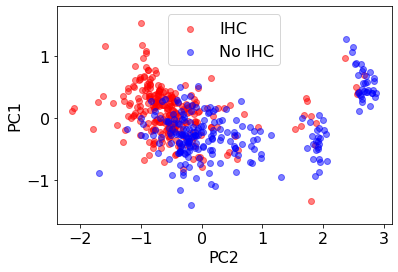

In [18]:
train_color_predicted = ['r' if label else 'b' for label in classifier.predict(train_signatures)]
test_color_predicted = ['r' if label else 'b' for label in classifier.predict(test_signatures)]
validation_color_predicted = ['r' if label else 'b' for label in classifier.predict(validation_signatures)]
ihc = np.concatenate((
    d2_train[np.array(train_color_predicted) == 'r'], 
    d2_test[np.array(test_color_predicted) == 'r'], 
    d2_validation[np.array(validation_color_predicted) == 'r'], 
))
no_ihc = np.concatenate((
    d2_train[np.array(train_color_predicted) == 'b'], 
    d2_test[np.array(test_color_predicted) == 'b'], 
    d2_validation[np.array(validation_color_predicted) == 'b'], 
))
plt.scatter(ihc[:, 0], ihc[:, 1], color='r', alpha=0.5)
plt.scatter(no_ihc[:, 0], no_ihc[:, 1], color='b', alpha=0.5)
plt.ylabel('PC1', fontsize=16)
plt.xlabel('PC2', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.gca().set_ylim((-1.7, 1.8))
# plt.title('Slide signatures with predicted labels', fontsize=20)
plt.legend(['IHC', 'No IHC'], fontsize=16)

(69, 2)


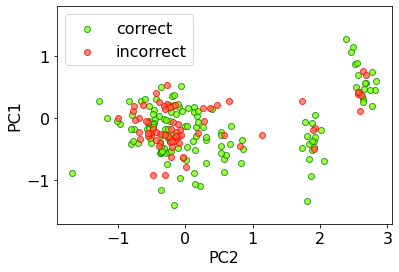

In [19]:
train_color_correct = ['r' if output == target else 'b' for output, target in zip(train_color_predicted, train_color)]
test_color_correct = ['r' if output == target else 'b' for output, target in zip(test_color_predicted, test_color)]
validation_color_correct = ['r' if output == target else 'b' for output, target in zip(validation_color_predicted, validation_color)]
from random import sample
correct = np.concatenate((
    d2_validation[np.array(validation_color_correct) == 'r'], 
))
incorrect = np.concatenate((
    d2_validation[np.array(validation_color_correct) == 'b'], 
))
print(incorrect.shape)
    
plt.scatter(correct[:, 0], correct[:, 1], color='chartreuse', edgecolor='g', alpha=0.75)
plt.scatter(incorrect[:, 0], incorrect[:, 1], color='tomato', edgecolor='r', alpha=0.75)
plt.ylabel('PC1', fontsize=16)
plt.xlabel('PC2', fontsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.gca().set_ylim((-1.7, 1.8))
# plt.title('Slide signatures with correct predictions', fontsize=20)
plt.legend(['correct', 'incorrect'], fontsize=16)

# feature importance

In [20]:
import eli5
from eli5.sklearn import PermutationImportance
from ihc.classify_slides_distribution import grid_search_on_random_forest

/Users/andreachatrian/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/andreachatrian/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [21]:
all_signatures = np.concatenate((train_signatures, test_signatures, validation_signatures))
all_labels = np.concatenate((train_labels, test_labels, validation_labels))
#_signatures = np.concatenate((all_signatures[:, :200], np.zeros((all_signatures.shape[0], 6))), axis=1)
perm = PermutationImportance(classifier, cv = 5, refit = False, n_iter = 10).fit(all_signatures, all_labels)

/Users/andreachatrian/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classifier=True as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


<BarContainer object of 206 artists>

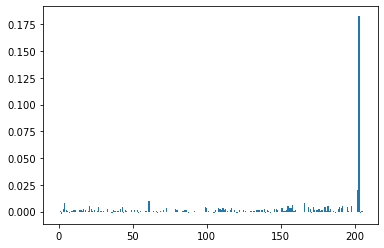

In [22]:
plt.bar(np.arange(len(perm.feature_importances_)), perm.feature_importances_)

In [23]:
from copy import deepcopy
classifier_copy = deepcopy(classifier)
classifier_copy.fit(np.concatenate((train_signatures, test_signatures)), np.concatenate((train_labels, test_labels)))
classifier_copy.score(validation_signatures, validation_labels)

0.6745283018867925

<BarContainer object of 206 artists>

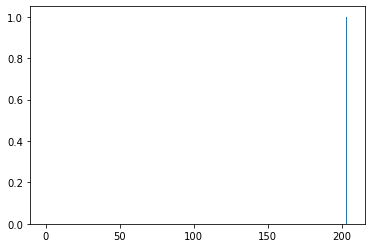

In [24]:
plt.bar(np.arange(len(perm.feature_importances_)), classifier_copy.feature_importances_)

In [25]:
classifier.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0.], dtype=float32)

# quantify difference in features between training/test and validation

In [26]:
from itertools import product

In [27]:
combinations = list(product(train_signatures, validation_signatures))

In [28]:
stds = np.std(np.concatenate((train_signatures, validation_signatures), axis=0))
standard_difference = np.sum((test - val)**2 for test, val in combinations)/stds/len(combinations)

/Users/andreachatrian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


<BarContainer object of 206 artists>

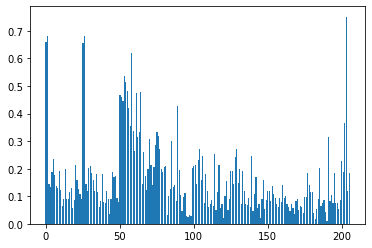

In [29]:
plt.bar(np.arange(len(perm.feature_importances_)), standard_difference)

(0.0, 2.0)

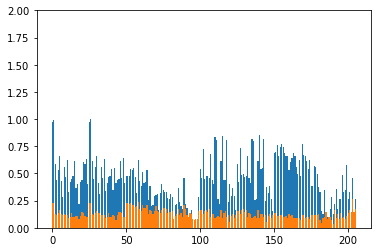

In [30]:
plt.bar(np.arange(len(perm.feature_importances_)), np.median(train_signatures, axis=0))
plt.bar(np.arange(len(perm.feature_importances_)), train_signatures.std(axis=0))
plt.gca().set_ylim((0, 2.0))

(0.0, 2.0)

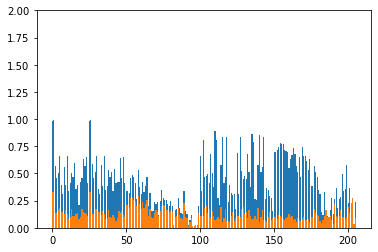

In [31]:
plt.bar(np.arange(len(perm.feature_importances_)), np.median(validation_signatures, axis=0))
plt.bar(np.arange(len(perm.feature_importances_)), validation_signatures.std(axis=0))
plt.gca().set_ylim((0, 2.0))

# view misclassified

In [32]:
validation_results_split0_path = '/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_20_10_20_00_validation_latest/results.json'
with open(validation_results_split0_path, 'r') as validation_results_split0_file:
    validation_results0 = json.load(validation_results_split0_file)
validation_results_split1_path = '/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_20_10_20_01_validation_latest/results.json'
with open(validation_results_split1_path, 'r') as validation_results_split1_file:
    validation_results1 = json.load(validation_results_split1_file)
validation_results_split2_path = '/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_20_10_20_02_validation_latest/results.json'
with open(validation_results_split2_path, 'r') as validation_results_split2_file:
    validation_results2 = json.load(validation_results_split2_file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/andreachatrian/Mounts/rescomp/gpfs2/well/rittscher/projects/IHC_Request/data/classifications/model_ensemble_residual_20_10_20_00_validation_latest/results.json'

In [ ]:
misclassified0 = set(validation_results0['misclassified'])
misclassified1 = set(validation_results1['misclassified'])
misclassified2 = set(validation_results2['misclassified'])
misclassified_common = set.intersection(misclassified0, misclassified1, misclassified2)

In [ ]:
misclassified_common